In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [48]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),        
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [49]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x
    return poten

In [50]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [51]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

La=0
Lb =200
L=Lb-La  # domain length
N = 12000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=50
extend_num=10
lr=0.01

hy_en=energy(en_num,l,b_lap,scale,device,dtype)
print('hy_en:',hy_en)

hy_en: tensor([-5.0000e+01, -1.2500e+01, -5.5556e+00, -3.1250e+00, -2.0000e+00,
        -1.3889e+00, -1.0204e+00, -7.8125e-01, -6.1728e-01, -5.0000e-01,
        -4.1322e-01, -3.4722e-01, -2.9586e-01, -2.5510e-01, -2.2222e-01,
        -1.9531e-01, -1.7301e-01, -1.5432e-01, -1.3850e-01, -1.2500e-01,
        -1.1338e-01, -1.0331e-01, -9.4518e-02, -8.6806e-02, -8.0000e-02,
        -7.3964e-02, -6.8587e-02, -6.3776e-02, -5.9453e-02, -5.5556e-02,
        -5.2029e-02, -4.8828e-02, -4.5914e-02, -4.3253e-02, -4.0816e-02,
        -3.8580e-02, -3.6523e-02, -3.4626e-02, -3.2873e-02, -3.1250e-02,
        -2.9744e-02, -2.8345e-02, -2.7042e-02, -2.5826e-02, -2.4691e-02,
        -2.3629e-02, -2.2635e-02, -2.1701e-02, -2.0825e-02, -2.0000e-02],
       device='cuda:0')


In [52]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])

en=eigenvalues[:en_num]

initial eigenvalues check:
tensor([-4.9658e+01, -1.2479e+01, -5.5512e+00, -3.1237e+00, -1.9996e+00,
        -1.3887e+00, -1.0204e+00, -7.8125e-01, -6.1725e-01, -4.9979e-01,
        -4.1279e-01, -3.4769e-01, -2.9558e-01, -2.5455e-01, -2.2157e-01,
        -1.9591e-01, -1.7280e-01, -1.4653e-01, -1.4476e-01, -1.2393e-01,
        -1.0814e-01, -1.0214e-01, -1.0060e-01, -8.4221e-02, -7.8967e-02,
        -7.5619e-02, -6.8366e-02, -6.2516e-02, -5.8235e-02, -5.4990e-02,
        -5.2894e-02, -4.6173e-02, -4.5731e-02, -3.6901e-02, -3.3713e-02,
        -2.5201e-02, -2.4383e-02, -1.2618e-02, -1.2514e-02, -4.5465e-04,
         4.1983e-03,  1.2397e-02,  2.1773e-02,  3.2771e-02,  3.9561e-02,
         4.9287e-02,  6.4403e-02,  6.6106e-02,  8.0252e-02,  8.8562e-02,
         9.9924e-02,  1.1322e-01,  1.2266e-01,  1.3348e-01,  1.4706e-01,
         1.5762e-01,  1.7044e-01,  1.7993e-01,  1.9555e-01,  2.0838e-01],
       device='cuda:0')


In [53]:
error=en-hy_en
print('error:')
print(error)
print('average error:',torch.mean(torch.abs(error)))

error:
tensor([ 3.4236e-01,  2.1398e-02,  4.3793e-03,  1.3340e-03,  3.7324e-04,
         2.0862e-04, -3.5882e-05, -4.1723e-07,  2.9385e-05,  2.1318e-04,
         4.3225e-04, -4.6560e-04,  2.8217e-04,  5.5522e-04,  6.5093e-04,
        -6.0120e-04,  2.1408e-04,  7.7929e-03, -6.2601e-03,  1.0650e-03,
         5.2400e-03,  1.1698e-03, -6.0813e-03,  2.5850e-03,  1.0329e-03,
        -1.6546e-03,  2.2129e-04,  1.2600e-03,  1.2181e-03,  5.6513e-04,
        -8.6487e-04,  2.6551e-03,  1.8261e-04,  6.3518e-03,  7.1034e-03,
         1.3379e-02,  1.2140e-02,  2.2008e-02,  2.0359e-02,  3.0795e-02,
         3.3943e-02,  4.0742e-02,  4.8815e-02,  5.8598e-02,  6.4252e-02,
         7.2917e-02,  8.7038e-02,  8.7808e-02,  1.0108e-01,  1.0856e-01],
       device='cuda:0')
average error: tensor(0.0246, device='cuda:0')


In [54]:
error_con=torch.tensor([ 7.5753e-01,  4.8524e-02,  9.6617e-03,  3.0136e-03,  1.3244e-03,
         6.2740e-04,  3.4583e-04,  2.4158e-04,  2.0653e-04,  1.6460e-04,
         1.1089e-04,  1.9050e-04,  1.4031e-04,  1.2290e-04,  4.2453e-04,
         9.1046e-06,  1.0560e-04,  3.5581e-04,  1.8130e-04,  8.8499e-04,
        -1.5475e-03,  1.9797e-03,  4.3754e-03,  1.0736e-02,  1.8738e-02,
         3.0742e-02,  4.3554e-02,  5.9071e-02,  7.6837e-02,  9.5466e-02,
         1.1568e-01,  1.3760e-01,  1.6088e-01,  1.8620e-01,  2.1247e-01,
         2.4023e-01,  2.6934e-01,  2.9957e-01,  3.3146e-01,  3.6410e-01,
         3.9801e-01,  4.3365e-01,  4.7010e-01,  5.0781e-01,  5.4669e-01,
         5.8658e-01,  6.2784e-01,  6.7004e-01,  7.1335e-01,  7.5792e-01],dtype=dtype,device=device)

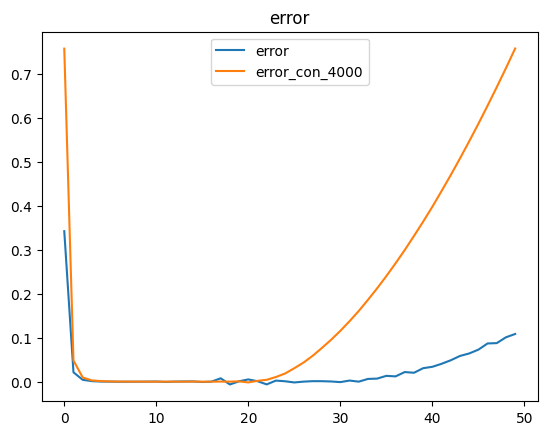

In [55]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(error_con.detach().cpu().numpy(),label='error_con_4000')
plt.legend()
plt.title('error')
plt.show()